STAT-627 Final Project


Name: Shu-Wen Teng, Yen-Jo Lee

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import requests
from io import StringIO

import sklearn as sk
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV


In [ ]:
# import data from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv"

response = requests.get(url)
response.raise_for_status()

data = StringIO(response.text)

df = pd.read_csv(data)

print(df.head())


       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8           

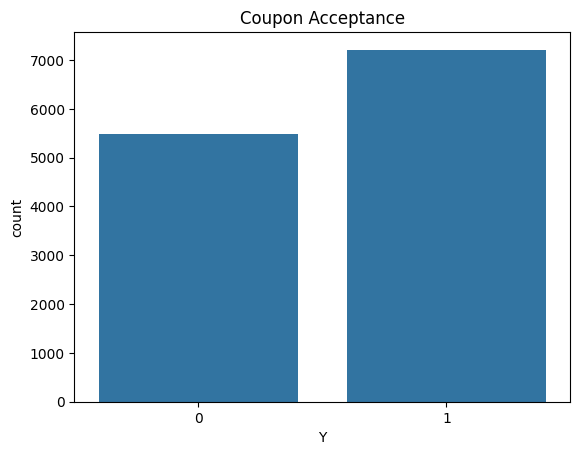

In [ ]:
#EDA
sns.countplot(x='Y', data=df)
plt.title('Coupon Acceptance')
plt.show()

From this plot, we can see that more respondents accepted the coupon than rejected it. This suggests that coupons are generally effective for most respondents, indicating that they can be a useful tool for influencing consumer behavior and encouraging engagement in various scenarios.


In [ ]:
#data cleaning
#drop some columns that contains missing values
columns_to_drop = ['occupation', 'car', 'education', 'income', 'passanger', 'direction_opp', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50','toCoupon_GEQ5min']
df = df.drop(columns=columns_to_drop)



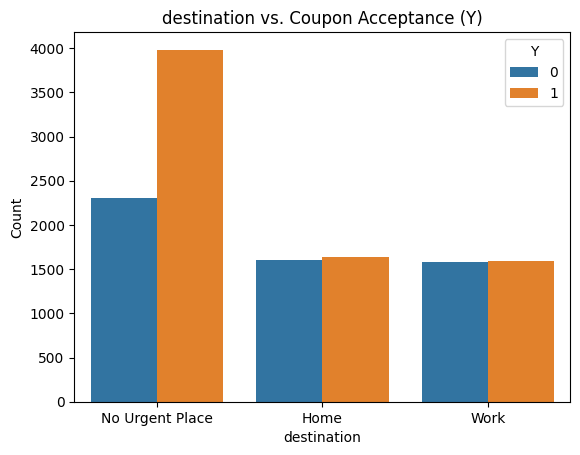

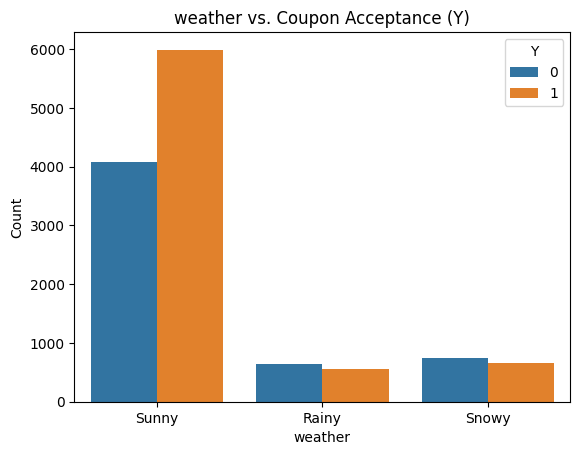

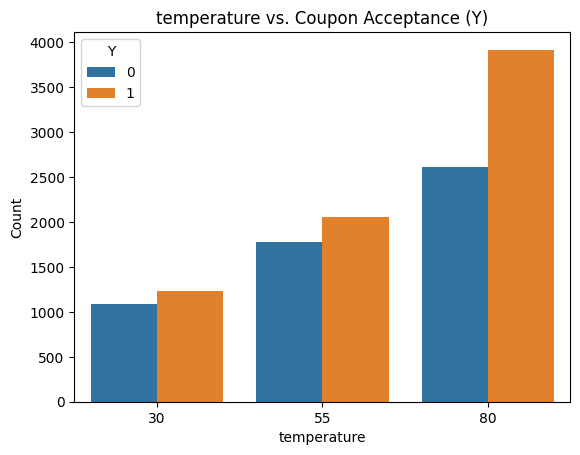

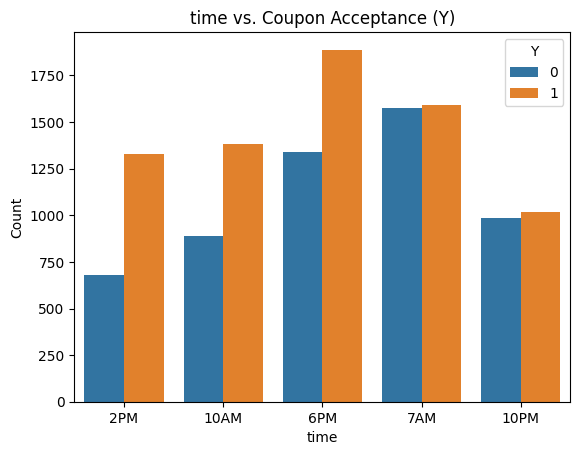

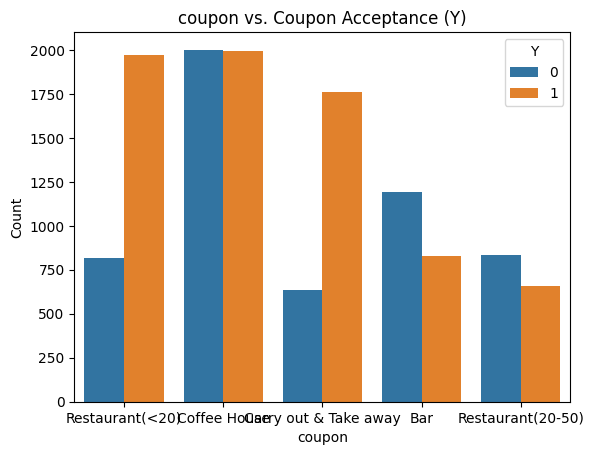

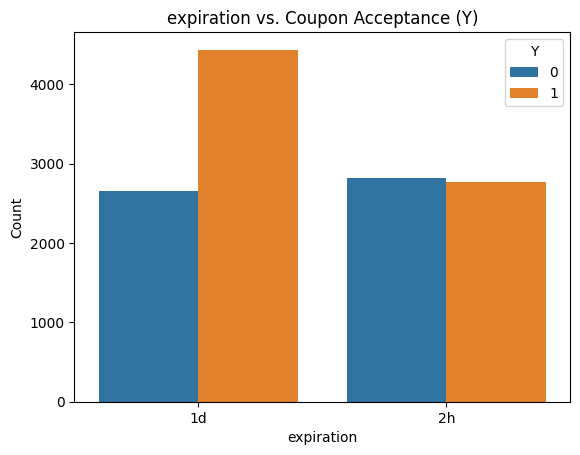

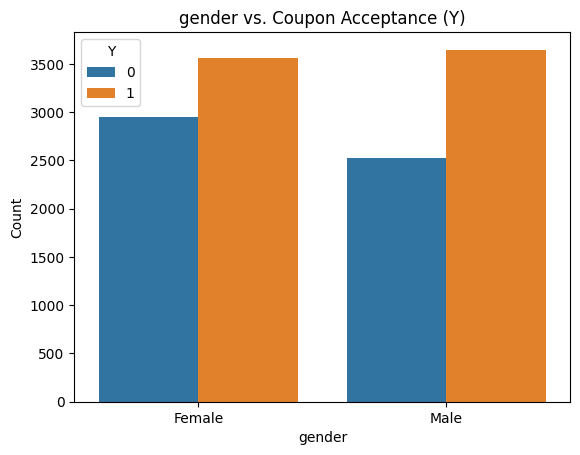

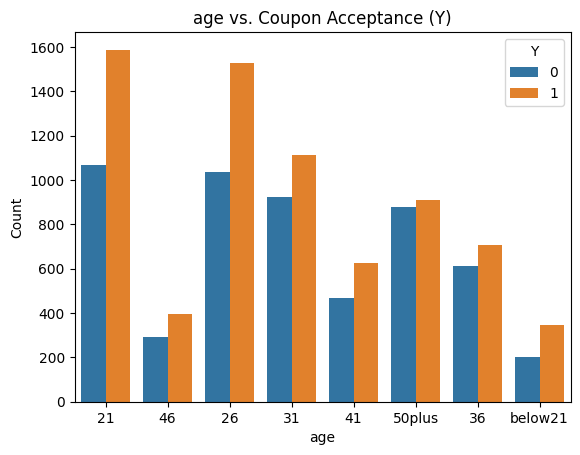

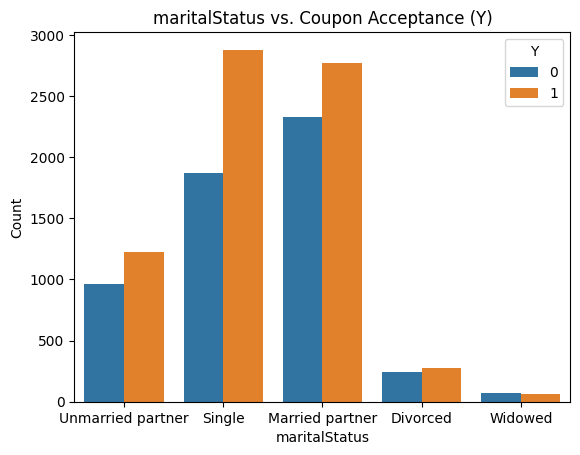

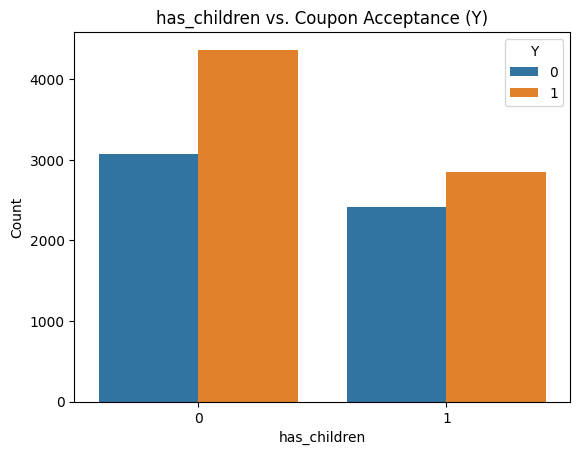

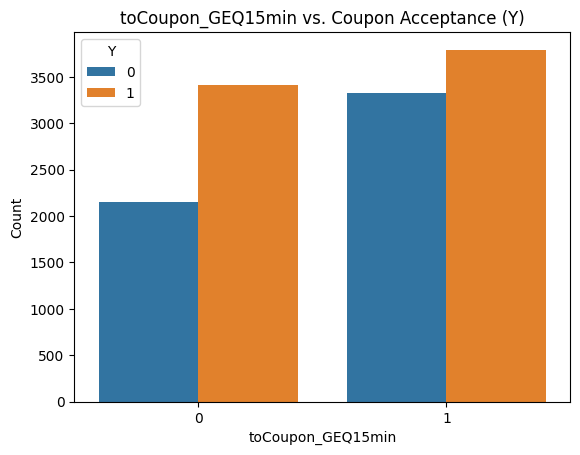

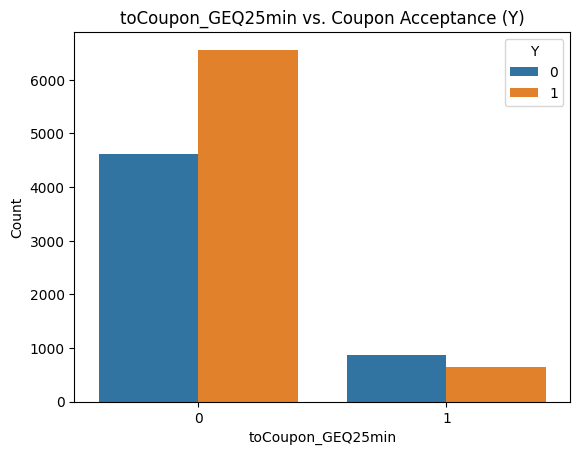

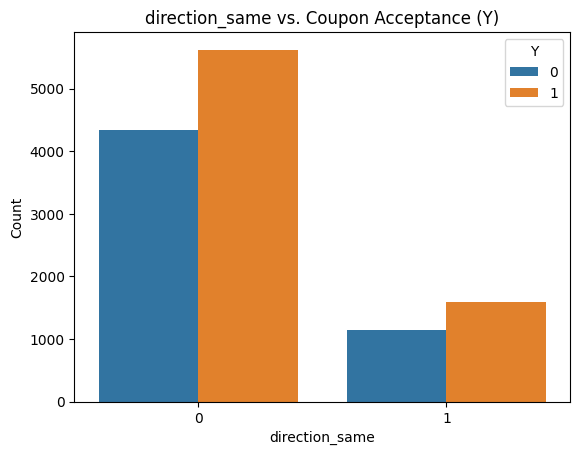

In [ ]:
#EDA
x_vars = ['destination', 'weather', 'temperature', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same']

for x_var in x_vars:
    # Create a countplot using seaborn
    sns.countplot(x=x_var, hue='Y', data=df)

    # Set plot title and labels
    plt.title(f'{x_var} vs. Coupon Acceptance (Y)')
    plt.xlabel(x_var)
    plt.ylabel('Count')

    # Display the plot
    plt.show()

Respondents without children were more likely to accept the coupon than reject it. On the other hand, respondents with children also showed a higher acceptance rate, but the difference between acceptance and rejection is smaller compared to those without children.
Overall, the presence of children may influence the decision-making process. However, both groups generally accepted the coupons more than they rejected them.

In [ ]:
#Assigning the numeric values to the string type variables
number = LabelEncoder()
df['destination'] = number.fit_transform(df['destination'])
df['weather'] = number.fit_transform(df['weather'])
df['time'] = number.fit_transform(df['time'])
df['coupon'] = number.fit_transform(df['coupon'])
df['expiration'] = number.fit_transform(df['expiration'])
df['gender'] = number.fit_transform(df['gender'])
df['maritalStatus'] = number.fit_transform(df['maritalStatus'])
df['age'] = number.fit_transform(df['age'])



In [ ]:
#Splitting data into 70% training and 30% testing
train_set, test_set = train_test_split(df, test_size=.3, random_state=42, shuffle=True, stratify=df['Y'])

X_train = train_set.iloc[:, :-1].values
X_test = test_set.iloc[:, :-1].values

y_train = train_set.iloc[:, -1].values
y_test = test_set.iloc[:, -1].values

In [ ]:
# LASSO features selection
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["Y"])
y = df["Y"]

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features:\n", selected_features)

In [ ]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

non_zero_coefficients = coefficients[coefficients['Coefficient'] != 0]

non_zero_coefficients

,Feature,Coefficient
0,destination,0.019349
1,weather,0.032685
2,temperature,0.009303
3,time,-0.036868
4,coupon,0.052098
5,expiration,-0.079247
6,gender,0.017881
7,age,-0.016215
8,maritalStatus,0.002921
9,has_children,-0.016643


<ipython-input-14-e4817d94a548>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coefficients, palette="viridis")


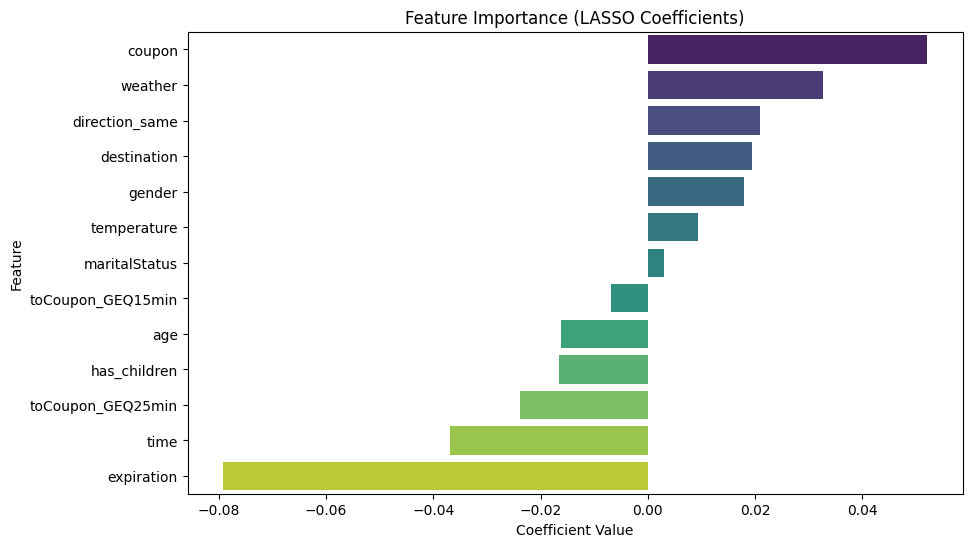

In [ ]:
coefficients = coefficients.sort_values(by="Coefficient", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefficients, palette="viridis")
plt.title("Feature Importance (LASSO Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [ ]:
#Logistic regression

xvars = ['destination', 'weather', 'temperature', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'has_children', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same']
X = df[xvars]
y = df['Y']

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.656566
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                12684
Model:                          Logit   Df Residuals:                    12671
Method:                           MLE   Df Model:                           12
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                 0.03976
Time:                        22:10:53   Log-Likelihood:                -8327.9
converged:                       True   LL-Null:                       -8672.7
Covariance Type:            nonrobust   LLR p-value:                7.234e-140
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
destination           0.1421      0.029      4.862      0.000       0.085       0.199
weather 

In [ ]:
LR = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [ ]:
y_pred_LR = LR.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_LR)}")
print(classification_report(y_test, y_pred_LR))
print(confusion_matrix(y_test, y_pred_LR))



Accuracy: 0.615606936416185
              precision    recall  f1-score   support

           0       0.59      0.37      0.46      1643
           1       0.63      0.80      0.70      2163

    accuracy                           0.62      3806
   macro avg       0.61      0.59      0.58      3806
weighted avg       0.61      0.62      0.60      3806

[[ 611 1032]
 [ 431 1732]]


In [ ]:
# 10-fold cross-validation MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring=mse_scorer)

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print("10-fold CV Mean Squared Error:", -(cv_scores_mean) )

10-fold CV Mean Squared Error: 0.38105124572148247


In [ ]:
# Decision Tree

DTC = DecisionTreeClassifier().fit(X_train, y_train)

y_pred_DTC = DTC.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_DTC)}")
print(classification_report(y_test, y_pred_DTC))
print(confusion_matrix(y_test, y_pred_DTC))


Accuracy: 0.617183394640042
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1643
           1       0.67      0.64      0.65      2163

    accuracy                           0.62      3806
   macro avg       0.61      0.61      0.61      3806
weighted avg       0.62      0.62      0.62      3806

[[ 970  673]
 [ 784 1379]]


In [ ]:
# 10-fold cross-validation MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(DTC, X_train, y_train, cv=10, scoring=mse_scorer)

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print("10-fold CV Mean Squared Error:", -(cv_scores_mean) )

10-fold CV Mean Squared Error: 0.37880254832058663


[Text(0.5, 0.875, 'coupon <= 3.5\ngini = 0.491\nsamples = 12684\nvalue = [5474, 7210]'),
 Text(0.25, 0.625, 'coupon <= 0.5\ngini = 0.498\nsamples = 9898\nvalue = [4658, 5240]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'has_children <= 0.5\ngini = 0.484\nsamples = 2017\nvalue = [1190, 827]'),
 Text(0.0625, 0.125, 'gini = 0.5\nsamples = 1142\nvalue = [577, 565]'),
 Text(0.1875, 0.125, 'gini = 0.42\nsamples = 875\nvalue = [613, 262]'),
 Text(0.375, 0.375, 'coupon <= 1.5\ngini = 0.493\nsamples = 7881\nvalue = [3468, 4413]'),
 Text(0.3125, 0.125, 'gini = 0.389\nsamples = 2393\nvalue = [633.0, 1760.0]'),
 Text(0.4375, 0.125, 'gini = 0.499\nsamples = 5488\nvalue = [2835, 2653]'),
 Text(0.75, 0.625, 'toCoupon_GEQ25min <= 0.5\ngini = 0.414\nsamples = 2786\nvalue = [816, 1970]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'expiration <= 0.5\ngini = 0.37\nsamples = 2476\nvalue = [607, 1869]'),
 Text(0.5625, 0.125, 'gini = 0.279\nsamples = 1321\nvalue = [221, 1100]'),
 Text(0.687

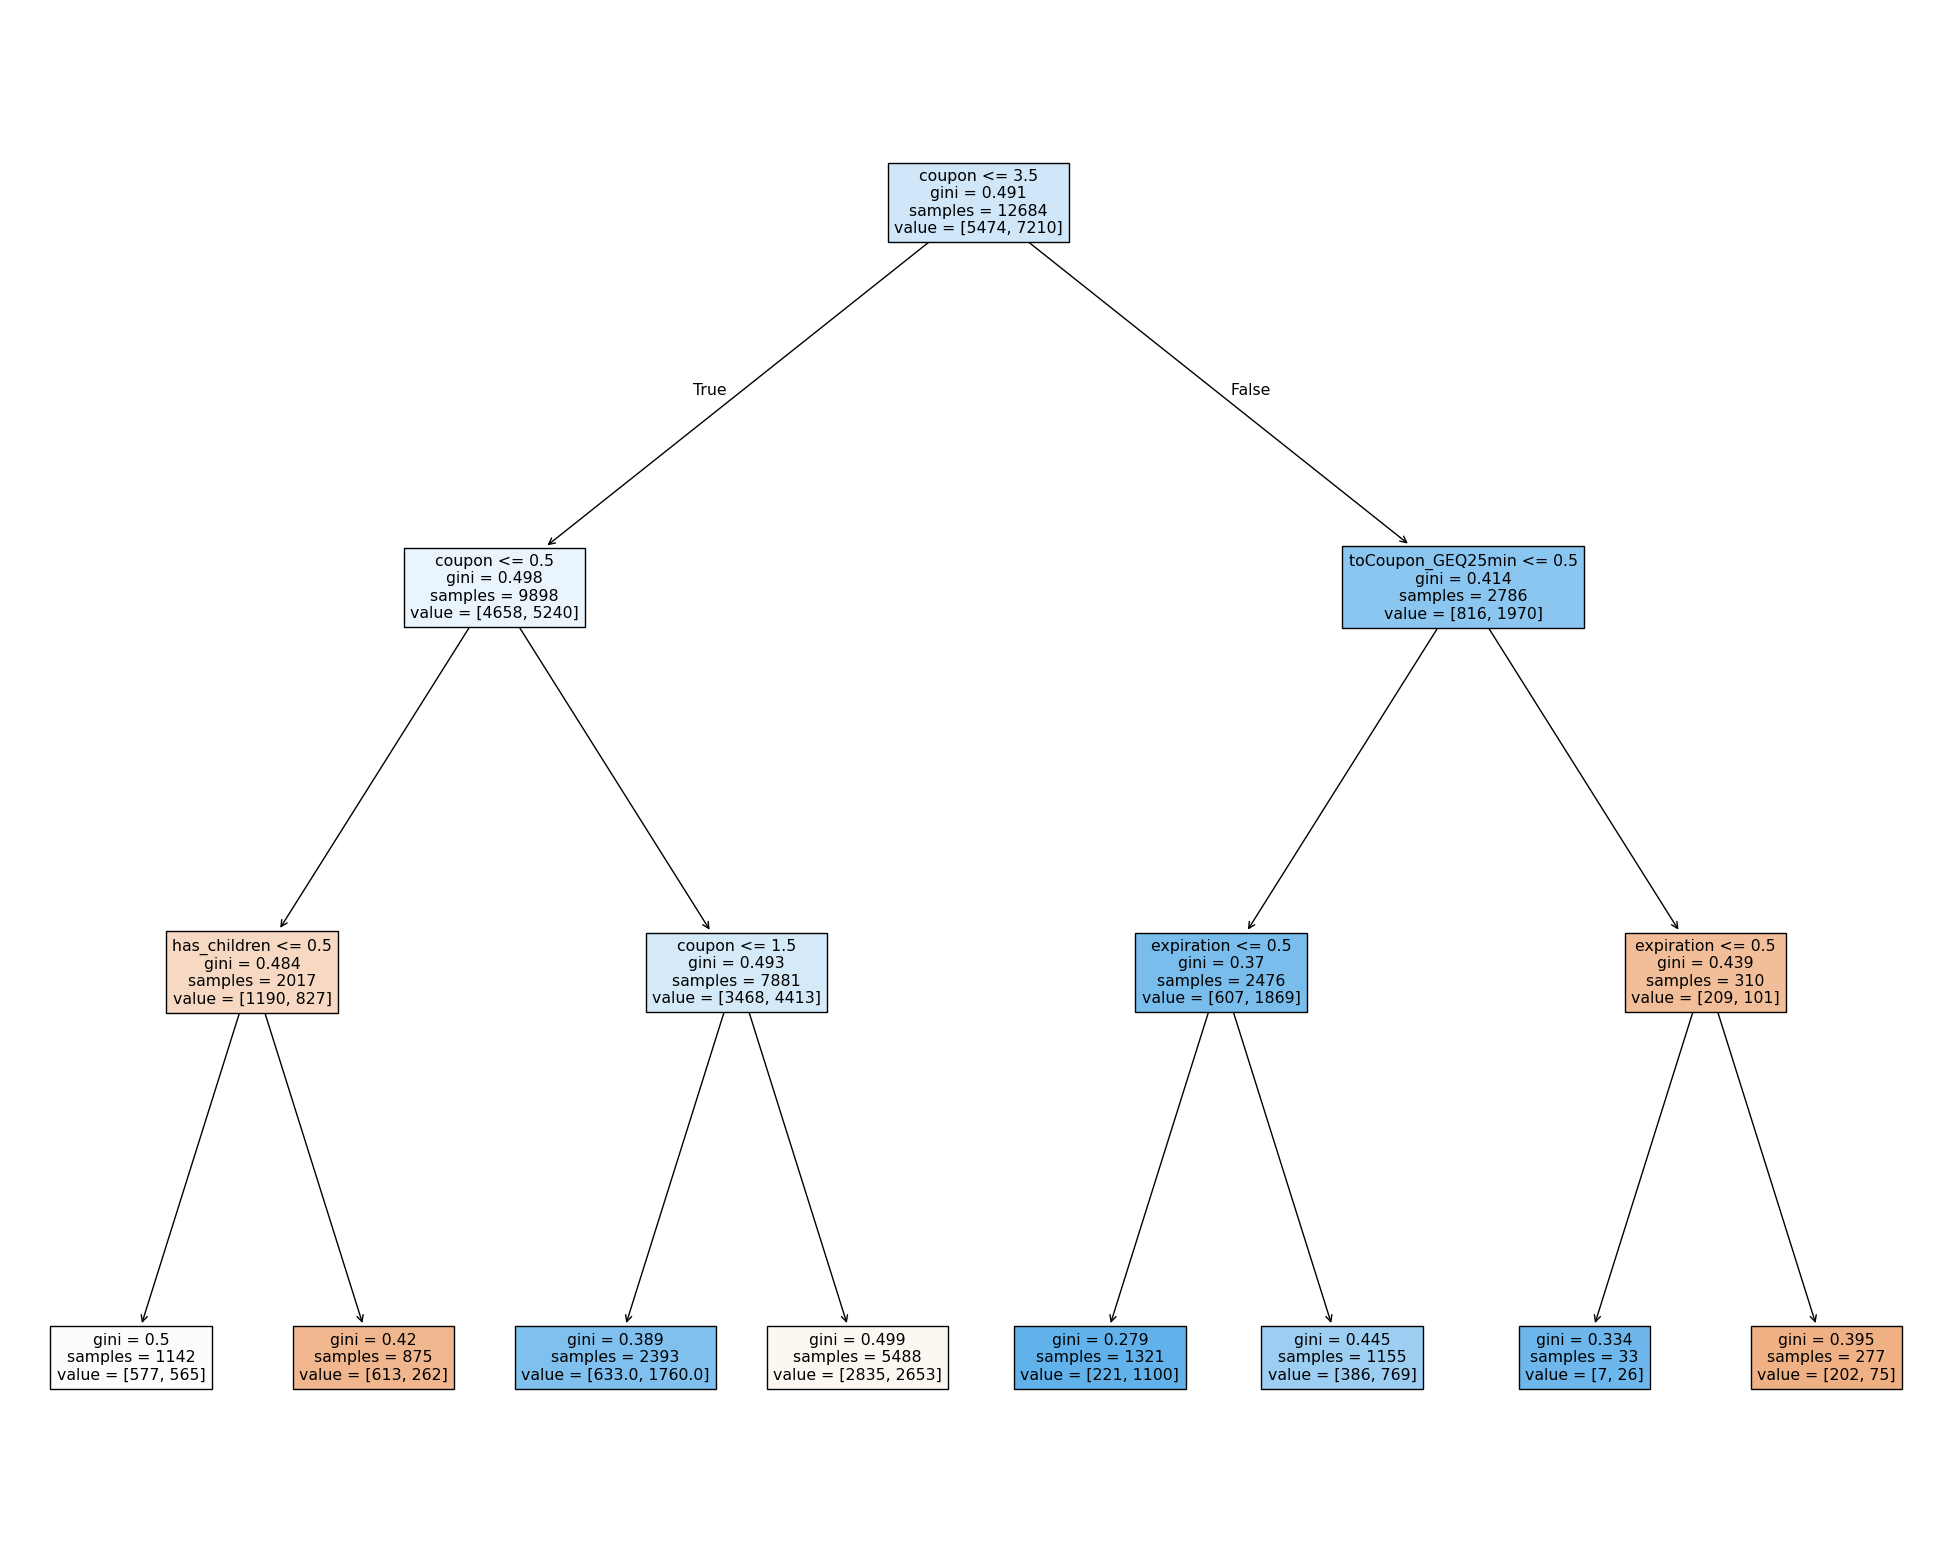

In [ ]:
#Decision tree plot

xvars = ['destination', 'weather', 'temperature', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'has_children', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same']
X = df[xvars]
y = df['Y']
small_tree_classifier = DecisionTreeClassifier(max_depth = 3).fit(X, y)


fig = plt.figure(figsize=(25,20))
plot_tree(small_tree_classifier, feature_names = xvars, filled = True)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
#KNN

KNN = KNeighborsClassifier().fit(X_train, y_train)

y_pred_KNN = KNN.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_KNN)}")
print(classification_report(y_test, y_pred_KNN))
print(confusion_matrix(y_test, y_pred_KNN))

Accuracy: 0.6347871781397793
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      1643
           1       0.66      0.72      0.69      2163

    accuracy                           0.63      3806
   macro avg       0.63      0.62      0.62      3806
weighted avg       0.63      0.63      0.63      3806

[[ 856  787]
 [ 603 1560]]


In [ ]:
# 10-fold cross-validation MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(KNN, X_train, y_train, cv=10, scoring=mse_scorer)

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print("10-fold CV Mean Squared Error:", -(cv_scores_mean) )

10-fold CV Mean Squared Error: 0.34917984500848087


In [ ]:
# LDA

LDA = LinearDiscriminantAnalysis().fit(X_train, y_train)

y_pred_LDA = LDA.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_LDA)}")
print(classification_report(y_test, y_pred_LDA))
print(confusion_matrix(y_test, y_pred_LDA))

Accuracy: 0.6142932212296374
              precision    recall  f1-score   support

           0       0.58      0.37      0.46      1643
           1       0.63      0.80      0.70      2163

    accuracy                           0.61      3806
   macro avg       0.60      0.59      0.58      3806
weighted avg       0.61      0.61      0.60      3806

[[ 613 1030]
 [ 438 1725]]


In [ ]:
# 10-fold cross-validation MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(LDA, X_train, y_train, cv=10, scoring=mse_scorer)

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print("10-fold CV Mean Squared Error:", -(cv_scores_mean) )

10-fold CV Mean Squared Error: 0.3811644931289802


In [ ]:
# Define the hyperparameter grid for LDA
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [0.01, 0.1, 1, None]
}

lda = LinearDiscriminantAnalysis()

grid_lda = GridSearchCV(lda, param_grid_lda, cv=10)
grid_lda.fit(X_train, y_train)

print(f"Best Parameters for LDA: {grid_lda.best_params_}")
print(f"Best Score for LDA: {grid_lda.best_score_}")

y_pred_lda = grid_lda.predict(X_test)
print(f"Accuracy on Test Set (LDA): {accuracy_score(y_test, y_pred_lda)}")

Best Parameters for LDA: {'shrinkage': None, 'solver': 'lsqr'}
Best Score for LDA: 0.6188355068710198
Accuracy on Test Set (LDA): 0.6142932212296374


In [ ]:
#SVM

SVM = SVC(kernel="rbf", random_state=None, probability=True, cache_size=500, gamma=0.1).fit(X_train, y_train)

y_pred_SVM = SVM.predict(X_test)


print(f"Accuracy: {accuracy_score(y_test, y_pred_SVM)}")
print(classification_report(y_test, y_pred_SVM))
print(confusion_matrix(y_test, y_pred_SVM))

Accuracy: 0.6592222806095639
              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1643
           1       0.67      0.80      0.73      2163

    accuracy                           0.66      3806
   macro avg       0.65      0.64      0.64      3806
weighted avg       0.66      0.66      0.65      3806

[[ 786  857]
 [ 440 1723]]


In this dataset, we hypothesized that the relationships between features and the target variable might not be linear, so we set the kernel= "rbf" (Radial Basis Function)

In [ ]:
# 10-fold cross-validation MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(SVM, X_train, y_train, cv=10, scoring=mse_scorer)

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print("10-fold CV Mean Squared Error:", -(cv_scores_mean) )

10-fold CV Mean Squared Error: 0.3274395167433499


In [ ]:
cm_SVM = confusion_matrix(y_test,y_pred_SVM)
pd.crosstab(y_test, y_pred_SVM, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,786,857,1643
1,440,1723,2163
All,1226,2580,3806


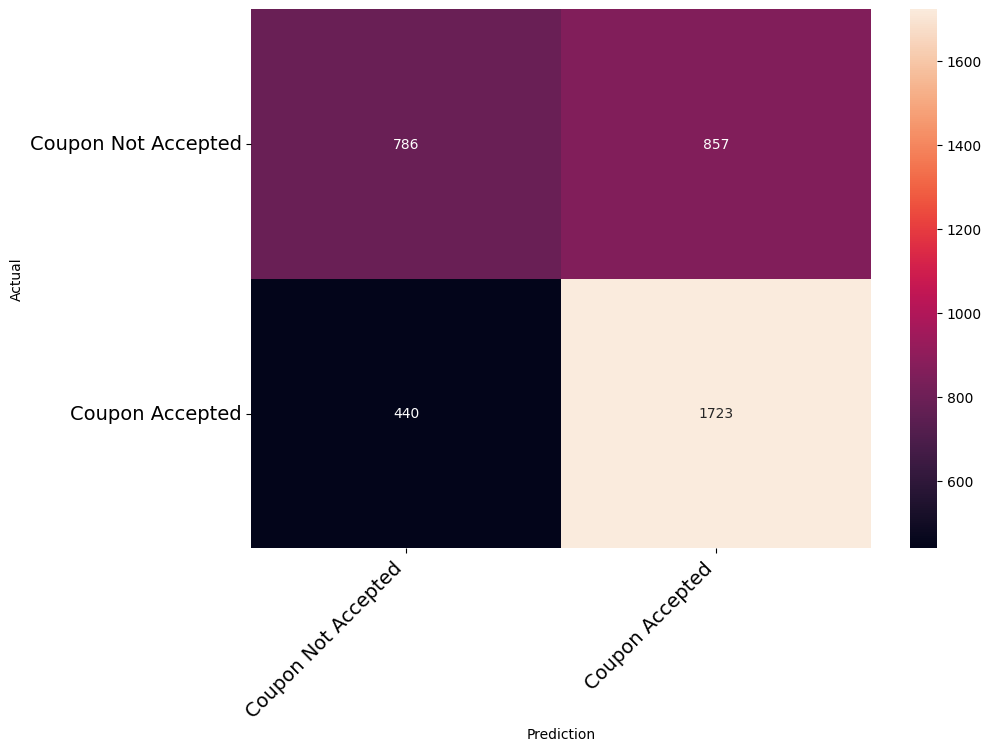

In [ ]:
#SVM confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Prediction')

print_confusion_matrix(cm_SVM,["Coupon Not Accepted", "Coupon Accepted"])

In [ ]:
#Hyperparameter Tuning

param_grid_kernels = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid_kernels = GridSearchCV(SVC(), param_grid_kernels, cv=10)


grid_kernels.fit(X_train, y_train)
print(f"Best Parameters with Kernel Tuning: {grid_kernels.best_params_}")
print(f"Best Score with Kernel Tuning: {grid_kernels.best_score_}")

Best Parameters with Kernel Tuning: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score with Kernel Tuning: 0.6745876372426541


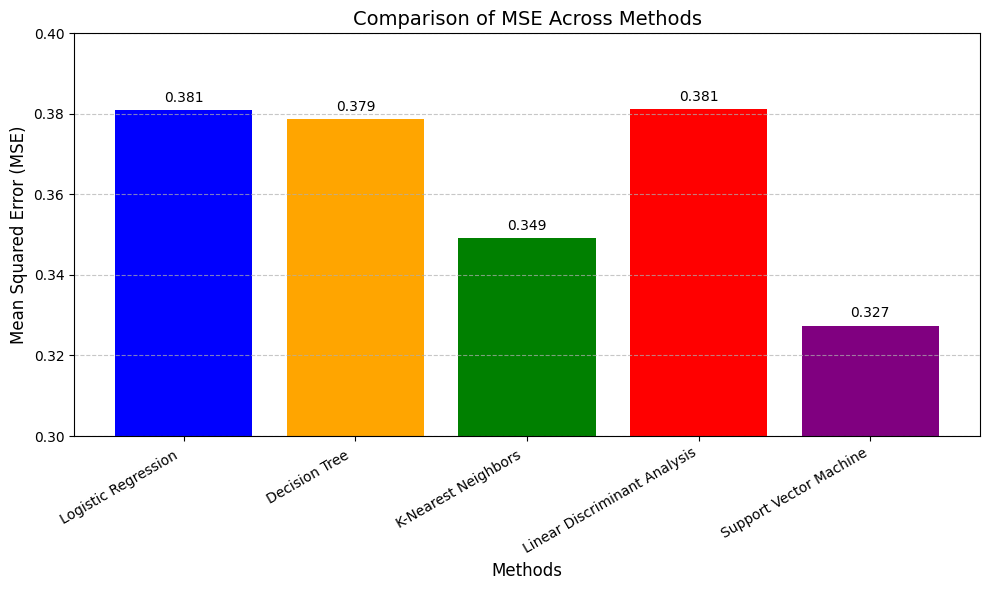

In [ ]:
#MSE plot
methods = ["Logistic Regression ", "Decision Tree ", "K-Nearest Neighbors ",
           "Linear Discriminant Analysis", "Support Vector Machine"]
mse_values = [0.38105124572148247, 0.37880254832058663, 0.34917984500848087,
              0.3811644931289802, 0.3274395167433499]

plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values, color=["blue", "orange", "green", "red", "purple"])
plt.xlabel("Methods", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title("Comparison of MSE Across Methods", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.ylim(0.3, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(mse_values):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
